# Import Libraries

In [57]:
# pip install rasterio

In [58]:
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
import pandas as pd
import numpy as np


import cv2
import rasterio


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K



from sklearn.metrics import *
from sklearn.model_selection import train_test_split


import pickle
from pathlib import Path
from PIL import Image
import tifffile as tiff


import os
import random

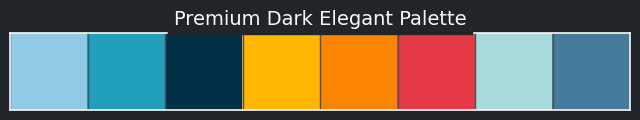

In [59]:
# Define a premium dark elegant color palette
dark_elegant_palette = [
    "#8ecae6",  # Light Blue Accent
    "#219ebc",  # Medium Blue
    "#023047",  # Deep Navy
    "#ffb703",  # Warm Yellow
    "#fb8500",  # Warm Orange
    "#e63946",  # Muted Red
    "#a8dadc",  # Soft Mint
    "#457b9d",  # Slate Blue
]

# Set a dark theme for Seaborn
sns.set_theme(
    style="darkgrid",              # Dark grid background
    palette=dark_elegant_palette,  # Custom color palette
    font="DejaVu Sans",
    rc={
        "axes.facecolor": "#212529",     # Dark background for axes
        "figure.facecolor": "#212529",   # Dark background for figure
        "axes.edgecolor": "#f8f9fa",     # Light axis lines
        "axes.labelcolor": "#f8f9fa",    # Light axis labels
        "text.color": "#f8f9fa",         # Light text
        "xtick.color": "#f8f9fa",        # Light tick labels
        "ytick.color": "#f8f9fa",
        "grid.color": "#495057",         # Muted gridlines
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.figsize": (8, 5),
        "axes.linewidth": 1.2,
    }
)

# Apply the palette to Matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=dark_elegant_palette)

# Preview the palette
sns.palplot(dark_elegant_palette)
plt.title("Premium Dark Elegant Palette", fontsize=14, color="#f8f9fa", backgroundcolor="#212529")
plt.show()

# Get and Explore Data

In [60]:
labels_path = '/kaggle/input/water-segmentation-data/data/labels'
images_path = '/kaggle/input/water-segmentation-data/data/images'

In [61]:
print(f"number of the labels = {len(os.listdir(labels_path))}")
print(f"number of the images = {len(os.listdir(images_path))}")

number of the labels = 306
number of the images = 306


In [62]:
def check_bad_images(base_path):
    bad_images = []
    good_images = []
    for file in (os.listdir(base_path)):
        if '_' in file:
            bad_images.append( file)
            os.remove(os.path.join(base_path, file))


    print("Bad images:", bad_images)

In [63]:
images = check_bad_images(images_path)


Bad images: []


In [64]:
labels = check_bad_images(labels_path)


Bad images: []


In [65]:
image_path = '/kaggle/input/water-segmentation-data/data/images/277.tif'

with rasterio.open(image_path) as img:
    print(f"Total Bands: {img.count}")
    for i in range(1, img.count + 1):
        channel = img.read(i)
        print(f"Band {i}: Shape {channel.shape}, Min {channel.min()}, Max {channel.max()}")

Total Bands: 12
Band 1: Shape (128, 128), Min 15, Max 685
Band 2: Shape (128, 128), Min 70, Max 1685
Band 3: Shape (128, 128), Min 177, Max 2009
Band 4: Shape (128, 128), Min 268, Max 2130
Band 5: Shape (128, 128), Min 3, Max 2905
Band 6: Shape (128, 128), Min -134, Max 3606
Band 7: Shape (128, 128), Min -60, Max 3310
Band 8: Shape (128, 128), Min 64, Max 240
Band 9: Shape (128, 128), Min 110, Max 128
Band 10: Shape (128, 128), Min 104, Max 150
Band 11: Shape (128, 128), Min 10, Max 80
Band 12: Shape (128, 128), Min 0, Max 96


| Band | Predicted Name               | Shape    | Min  | Max  | Notes                                                                 |
|------|------------------------------|----------|------|------|-----------------------------------------------------------------------|
| 1    | Coastal Aerosol              | 128×128  | 15   | 685  | Detects haze/coastal features. Low reflectance range.                 |
| 2    | Blue                         | 128×128  | 70   | 1685 | Water penetration band. Higher max suggests vegetation influence.    |
| 3    | Green                        | 128×128  | 177  | 2009 | Chlorophyll reflectance peak. Critical for NDWI.                      |
| 4    | Red                          | 128×128  | 268  | 2130 | Strong water absorption. Land/vegetation shows high reflectance.      |
| 5    | NIR (Near-Infrared)          | 128×128  | 3    | 2905 | Near-zero = water. Max = healthy vegetation. Key for water masking.   |
| 6    | SWIR1                        | 128×128  | -134 | 3606 | Moisture-sensitive. Negative values may need clipping.                |
| 7    | SWIR2                        | 128×128  | -60  | 3310 | Stronger water absorption than SWIR1. Dry land shows high values.     |
| 8    | Panchromatic                 | 128×128  | 64   | 240  | High-res band. Narrow range suggests grayscale enhancement.           |
| 9    | Cirrus                       | 128×128  | 110  | 128  | Detects high-altitude ice clouds. Minimal variation in this scene.    |
| 10   | Thermal Infrared 1 (TIRS1)    | 128×128  | 104  | 150  | Surface temperature. Stable values suggest uniform thermal profile.   |
| 11   | Thermal Infrared 2 (TIRS2)    | 128×128  | 10   | 80   | Secondary thermal band. May require atmospheric correction.           |
| 12   | Water Occurrence/QA Band      | 128×128  | 0    | 96   | Likely water probability (0-100%) or quality flags.                   |

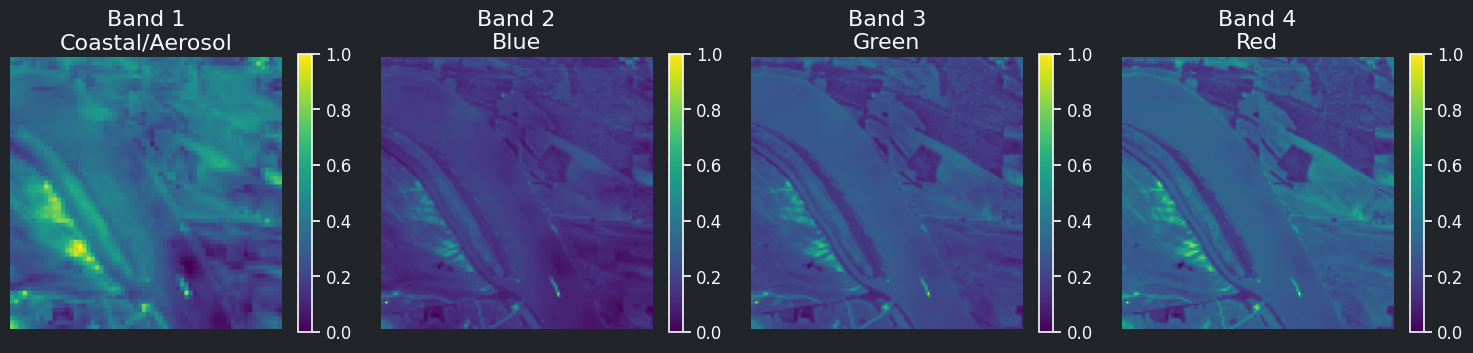

In [66]:
# Construct the full path to the target image file
img_file = os.path.join(images_path, '277.tif')
img_data = tiff.imread(img_file)

# Function to scale pixel values of a single channel to the range [0, 1]
def scale_channel(channel_data):
    min_pixel = np.min(channel_data)
    max_pixel = np.max(channel_data)
    return (channel_data - min_pixel) / (max_pixel - min_pixel)

# Define bands to display
selected_bands = {
    1: 'Coastal/Aerosol',
    2: 'Blue',
    3: 'Green',
    4: 'Red'
}

# Create a grid to display all bands together
fig, axes = plt.subplots(1, len(selected_bands), figsize=(15, 5))  # 1 row, N columns

for ax, (idx, name) in zip(axes, selected_bands.items()):
    scaled_band = scale_channel(img_data[:, :, idx - 1])
    im = ax.imshow(scaled_band, cmap='viridis')
    ax.set_title(f'Band {idx}\n{name}')
    ax.axis('off')  # Hide axis ticks
    fig.colorbar(im, ax=ax, shrink=0.6)  # Add color bar to each subplot

plt.tight_layout()
plt.show()

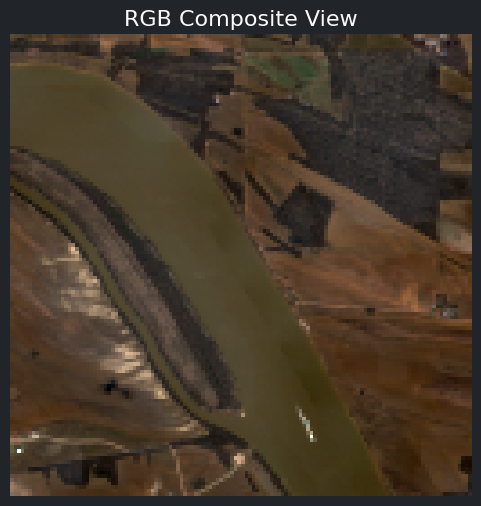

In [67]:
# Extract and normalize the bands for RGB composition
red = scale_channel(img_data[:, :, 3])    # Red band (Band 4)
green = scale_channel(img_data[:, :, 2])  # Green band (Band 3)
blue = scale_channel(img_data[:, :, 1])   # Blue band (Band 2)

# Combine the bands into a single RGB image
rgb_composite = np.dstack((red, green, blue))

# Display the RGB composite image
plt.figure(figsize=(6, 6))
plt.imshow(rgb_composite)
plt.title('RGB Composite View')
plt.axis('off')  # Hide axis ticks for a cleaner look
plt.show()

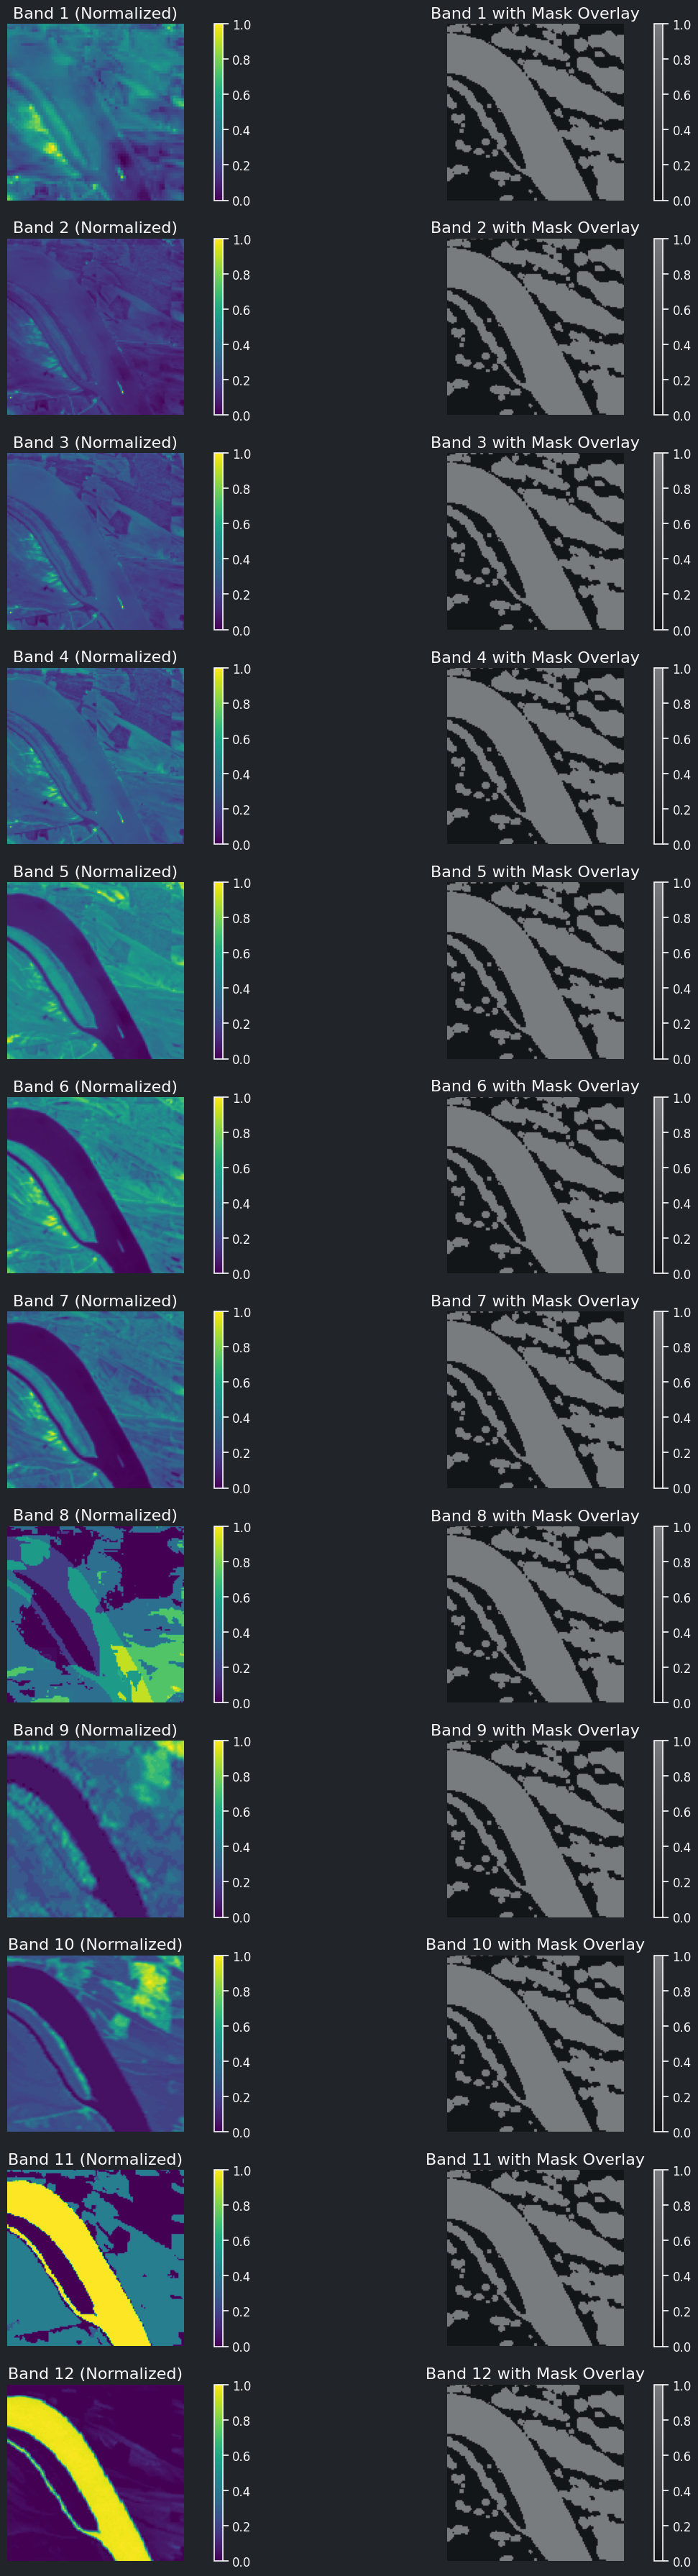

In [68]:
# Function to scale pixel values of a single channel to the range [0, 1]
def scale_channel(channel_data):
    min_pixel = np.min(channel_data)
    max_pixel = np.max(channel_data)
    # Handle cases where min_pixel equals max_pixel to avoid division by zero
    if max_pixel == min_pixel:
        return np.zeros_like(channel_data, dtype=np.float32)
    return (channel_data - min_pixel) / (max_pixel - min_pixel)

# Load the mask image
mask_file = os.path.join(labels_path, '277.png')  # Update path if necessary
mask_data = plt.imread(mask_file)

# Ensure mask is binary (0 or 1)
# Assuming the mask is grayscale and water is represented by a specific value (e.g., white)
# You might need to adjust the threshold based on your mask data
mask_binary = (mask_data > 0).astype(np.uint8)


# Construct the full path to the target image file
img_file = os.path.join(images_path, '277.tif')
img_data = tiff.imread(img_file)

# Get the number of bands
num_bands = img_data.shape[2]

# Create plots for each band with mask overlay
plt.figure(figsize=(15, num_bands * 3)) # Adjust figure size based on number of bands

for band_idx in range(num_bands):
    band_data = img_data[:, :, band_idx]
    scaled_band = scale_channel(band_data)

    plt.subplot(num_bands, 2, 2 * band_idx + 1)
    plt.imshow(scaled_band, cmap='viridis')
    plt.title(f'Band {band_idx + 1} (Normalized)')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(num_bands, 2, 2 * band_idx + 2)
    # plt.imshow(scaled_band, cmap='viridis', alpha=0.6) # Base layer
    plt.imshow(mask_binary, cmap='gray', alpha=0.4) # Overlay mask
    plt.title(f'Band {band_idx + 1} with Mask Overlay')
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()

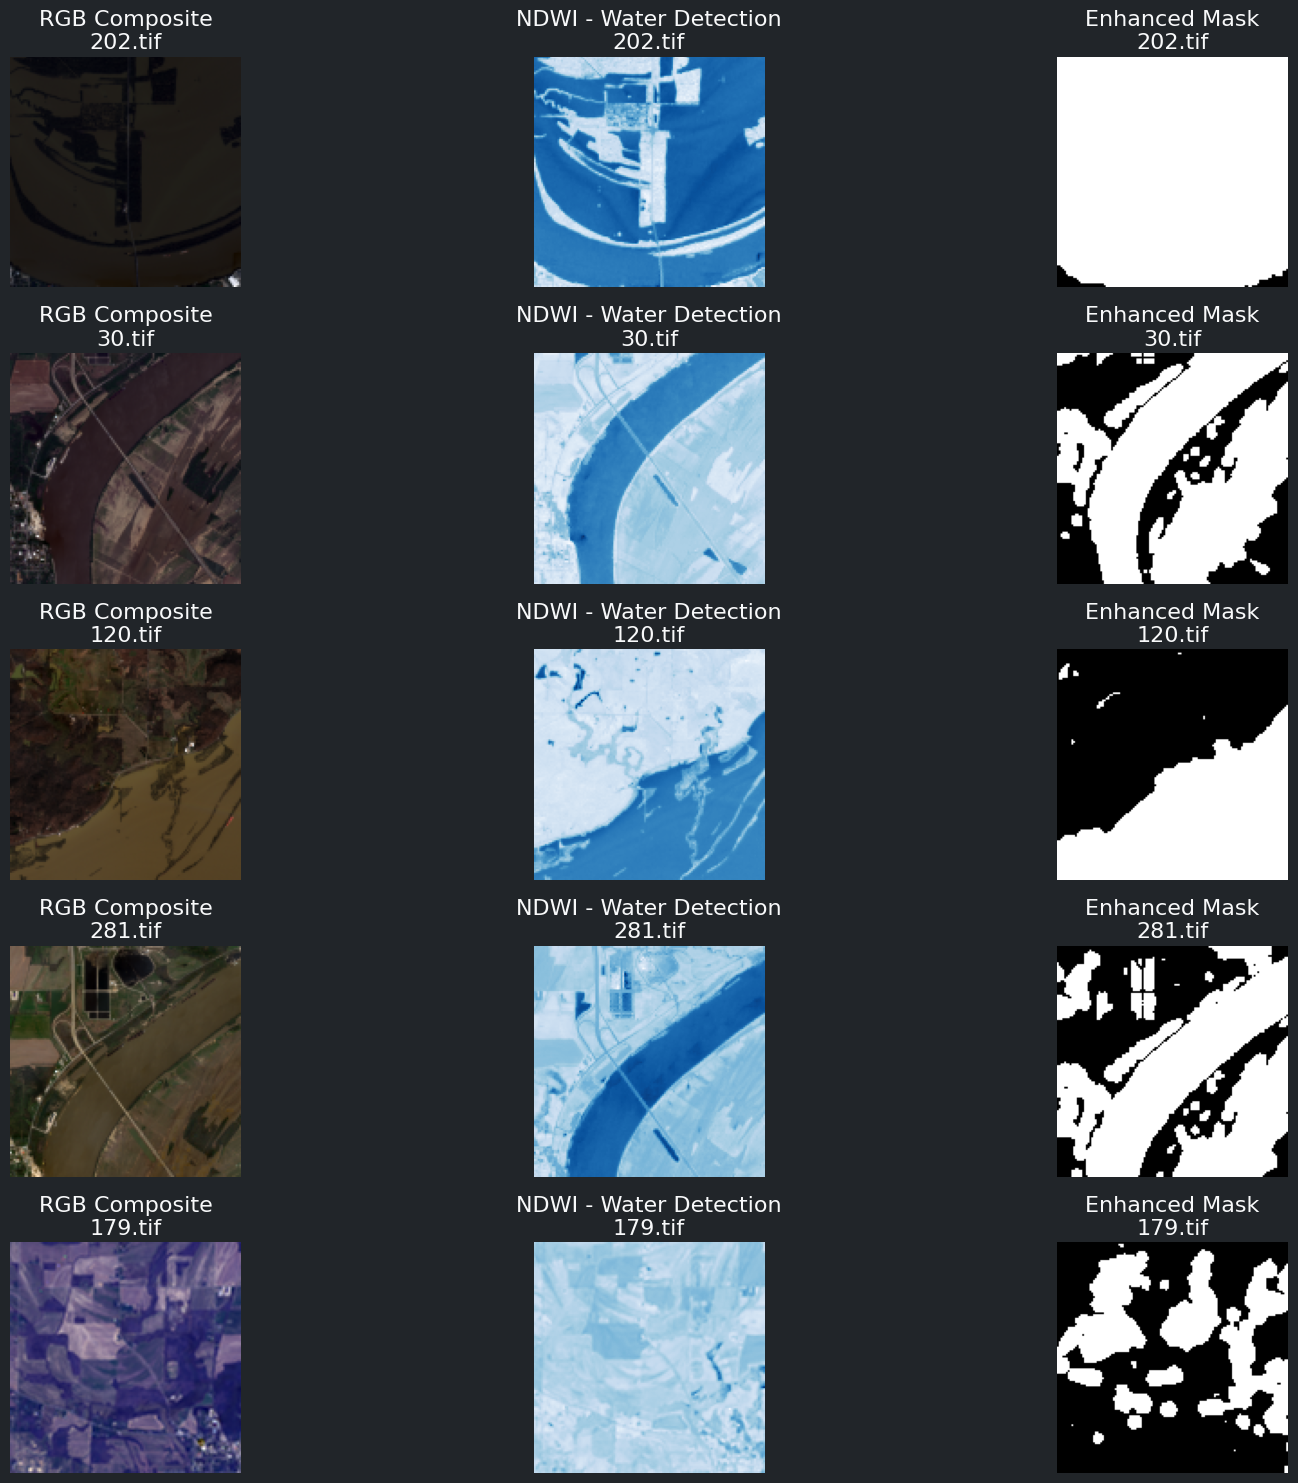

In [69]:
def scale_band(band):
    """Scale band values to [0, 1] for visualization."""
    return (band - np.min(band)) / (np.max(band) - np.min(band) + 1e-8)

def enhance_mask(mask):
    """
    Enhance the contrast of a mask image.
    Assumes mask pixel values are in [0, 1].
    """
    mask_array = np.array(mask)
    enhanced = (mask_array * 255).clip(0, 255).astype(np.uint8)
    return enhanced

def process_and_visualize(images_dir, masks_dir, num_samples=10):
    """
    Randomly select images and visualize:
    - RGB composite
    - NDWI (water index)
    - Enhanced mask overlay
    """
    images_path = Path(images_dir)
    masks_path = Path(masks_dir)

    # Get random sample of .tif files
    tif_files = list(images_path.glob('*.tif'))
    if num_samples > len(tif_files):
        raise ValueError(f"Requested {num_samples} samples but only found {len(tif_files)} images.")

    selected_files = random.sample(tif_files, num_samples)

    # Create a figure with 3 columns: RGB, NDWI, Mask
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, num_samples * 3))

    for i, img_file in enumerate(selected_files):
        # Load image and corresponding mask
        img = tiff.imread(img_file)
        mask_file = masks_path / (img_file.stem + ".png")
        mask = Image.open(mask_file)

        # Process bands
        blue = scale_band(img[:, :, 1])   # Band 2
        green = scale_band(img[:, :, 2])  # Band 3
        red = scale_band(img[:, :, 3])    # Band 4
        nir = scale_band(img[:, :, 4])    # Band 5

        rgb_composite = np.dstack((red, green, blue))
        ndwi = (green - nir) / (green + nir + 1e-8)
        mask_enhanced = enhance_mask(mask)

        # Plot RGB composite
        ax_rgb = axes[i, 0] if num_samples > 1 else axes[0]
        ax_rgb.imshow(rgb_composite)
        ax_rgb.set_title(f'RGB Composite\n{img_file.name}')
        ax_rgb.axis('off')

        # Plot NDWI
        ax_ndwi = axes[i, 1] if num_samples > 1 else axes[1]
        ax_ndwi.imshow(ndwi, cmap='Blues')
        ax_ndwi.set_title(f'NDWI - Water Detection\n{img_file.name}')
        ax_ndwi.axis('off')

        # Plot enhanced mask
        ax_mask = axes[i, 2] if num_samples > 1 else axes[2]
        ax_mask.imshow(mask_enhanced, cmap='gray')
        ax_mask.set_title(f'Enhanced Mask\n{img_file.name}')
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
process_and_visualize(images_dir=images_path, masks_dir=labels_path, num_samples=5)

# Preprocessing

In [70]:
def load_images_and_masks(images_dir, masks_dir, mask_threshold=0):
    """
    Load all .tif images and their corresponding masks.

    Args:
        images_dir (str or Path): Path to directory containing .tif images.
        masks_dir (str or Path): Path to directory containing mask images (.png).
        mask_threshold (int): Pixel values above this threshold are set to 1.

    Returns:
        images (np.ndarray): Array of loaded images.
        masks (np.ndarray): Array of binary masks.
    """
    images_path = Path(images_dir)
    masks_path = Path(masks_dir)

    image_files = sorted(images_path.glob('*.tif'))  # Sorted for consistent order

    images = []
    masks = []

    for img_file in image_files:
        # Load image
        img = tiff.imread(img_file)

        # Locate corresponding mask
        mask_file = masks_path / (img_file.stem + ".png")
        if not mask_file.exists():
            print(f"⚠️ Warning: Mask not found for {img_file.name}. Skipping.")
            continue

        # Load and binarize mask
        mask = np.array(Image.open(mask_file))
        binary_mask = (mask > mask_threshold).astype(np.uint8)

        images.append(img)
        masks.append(binary_mask)

    # Convert lists to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    print(f"✅ Loaded {len(images)} images with shape {images.shape}")
    print(f"✅ Loaded {len(masks)} masks with shape {masks.shape}")

    return images, masks

# Example usage
images, masks = load_images_and_masks(images_path, labels_path)

✅ Loaded 306 images with shape (306, 128, 128, 12)
✅ Loaded 306 masks with shape (306, 128, 128)


In [71]:
def normalize_image(image):
    """
    Normalize each band of a multi-channel image to [0, 1].
    If a band has constant values (min == max), fill it with zeros.

    Args:
        image (np.ndarray): Multi-channel image (H x W x C).

    Returns:
        np.ndarray: Normalized image with dtype float32.
    """
    norm_img = np.zeros_like(image, dtype=np.float32)

    for band_idx in range(image.shape[2]):
        band = image[:, :, band_idx]
        min_val, max_val = np.min(band), np.max(band)
        if max_val > min_val:
            norm_img[:, :, band_idx] = (band - min_val) / (max_val - min_val)
        else:
            norm_img[:, :, band_idx] = 0.0  # Constant value if band is flat

    return norm_img
images_normalized = np.array([normalize_image(img) for img in images])

In [72]:
# Select specific bands (0-indexed)
selected_bands_indices = [6, 7, 11]
images_selected_bands = images_normalized[:, :, :, selected_bands_indices]

print(f"Shape of images with selected bands: {images_selected_bands.shape}")

Shape of images with selected bands: (306, 128, 128, 3)


In [73]:
X_train, X_val, y_train, y_val = train_test_split(images_selected_bands, masks, test_size=0.3, random_state=42)

In [74]:
print(f"Train_x:{len(X_train)}")
print(f"Train_y:{len(y_train)}")

print(f"Test_x:{len(X_val)}")
print(f"Test_y:{len(y_val)}")

Train_x:214
Train_y:214
Test_x:92
Test_y:92


In [75]:
print(np.isnan(images).sum(), np.isinf(images).sum())
print(np.isnan(images_selected_bands).sum(), np.isinf(images_selected_bands).sum())
print(np.isnan(images_normalized).sum(), np.isinf(images_normalized).sum())
print(np.isnan(masks).sum(), np.isinf(masks).sum())

0 0
0 0
0 0
0 0


# Modeling

## Trying Resnet50 without any freezing

In [93]:
# pip install segmentation-models==1.0.1

In [94]:
os.environ["SM_FRAMEWORK"] = "tf.keras"  # Set the framework before importing

import segmentation_models as sm
from segmentation_models import Unet  # Import directly
from tensorflow.keras import layers, Model

# Set ResNet backbone
BACKBONE = 'resnet50'

In [95]:
model = Unet(
    backbone_name=BACKBONE,
    encoder_weights='imagenet',  # Use ImageNet weights
    input_shape=(128, 128, 3),  # Change if using more than 3 bands
    classes=1,
    activation='sigmoid'
)


In [96]:
def iou(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Expand dims if y_true has shape [B, H, W]
    if len(y_true.shape) == 3:
        y_true = tf.expand_dims(y_true, axis=-1)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    if len(y_true.shape) == 3:
        y_true = tf.expand_dims(y_true, axis=-1)

    intersection = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + smooth) / (total + smooth)


In [97]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy",dice_coefficient, iou]
)

In [98]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_unet_model.keras",
    monitor="val_iou",
    mode="max",
    save_best_only=True,
    verbose=1
)

callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    checkpoint_callback
]

In [99]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[callbacks],
    batch_size=16
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6617 - dice_coefficient: 0.4074 - iou: 0.2586 - loss: 0.6067   
Epoch 1: val_iou improved from -inf to 0.11029, saving model to best_unet_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.6684 - dice_coefficient: 0.4114 - iou: 0.2620 - loss: 0.6002 - val_accuracy: 0.7266 - val_dice_coefficient: 0.1979 - val_iou: 0.1103 - val_loss: 1.6742 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8701 - dice_coefficient: 0.5994 - iou: 0.4309 - loss: 0.3447
Epoch 2: val_iou did not improve from 0.11029
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.8695 - dice_coefficient: 0.5971 - iou: 0.4292 - loss: 0.3454 - val_accuracy: 0.7698 - val_dice_coefficient: 0.0238 - val_iou: 0.0120 - val_loss: 3.1733 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8775 - dice_coefficient: 0.6408 - iou: 0.4730 - loss: 0.3004
Epoch 3: val_iou did no

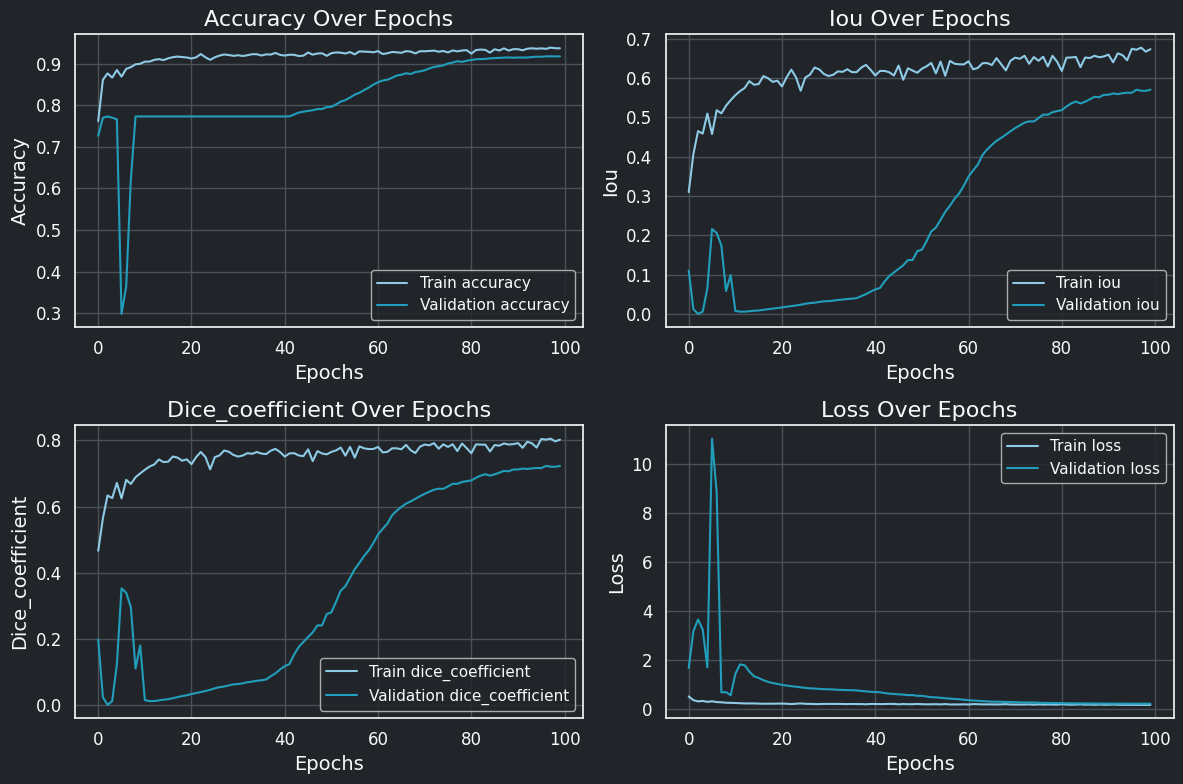

In [100]:
metrics = ["accuracy", "iou", "dice_coefficient", "loss"]
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1) 
    plt.plot(history.history[metric], label=f"Train {metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
best_model = tf.keras.models.load_model("best_unet_model.keras", custom_objects={"iou": iou, "dice_coefficient": dice_coefficient})
best_val_iou = max(history.history["val_iou"])  
best_val_dice = max(history.history["val_dice_coefficient"])  
best_val_acc = max(history.history["val_accuracy"])  
best_val_loss = min(history.history["val_loss"])  # Best (lowest) validation loss

print(f"Best Validation IoU: {best_val_iou:.4f}")
print(f"Best Validation Dice Coefficient: {best_val_dice:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# # Print the summary of the best model
best_model.summary()

Best Validation IoU: 0.5700
Best Validation Dice Coefficient: 0.7229
Best Validation Accuracy: 0.9178
Best Validation Loss: 0.2100


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_90   │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │      9,408 │ zero_padding2d_9… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_91   │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_92   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_9… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 32, 32,    │          0 │ stage1_unit1_bn3

 Total params: 97,588,228 (372.27 MB)

 Trainable params: 32,513,556 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

 Optimizer params: 65,027,114 (248.06 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


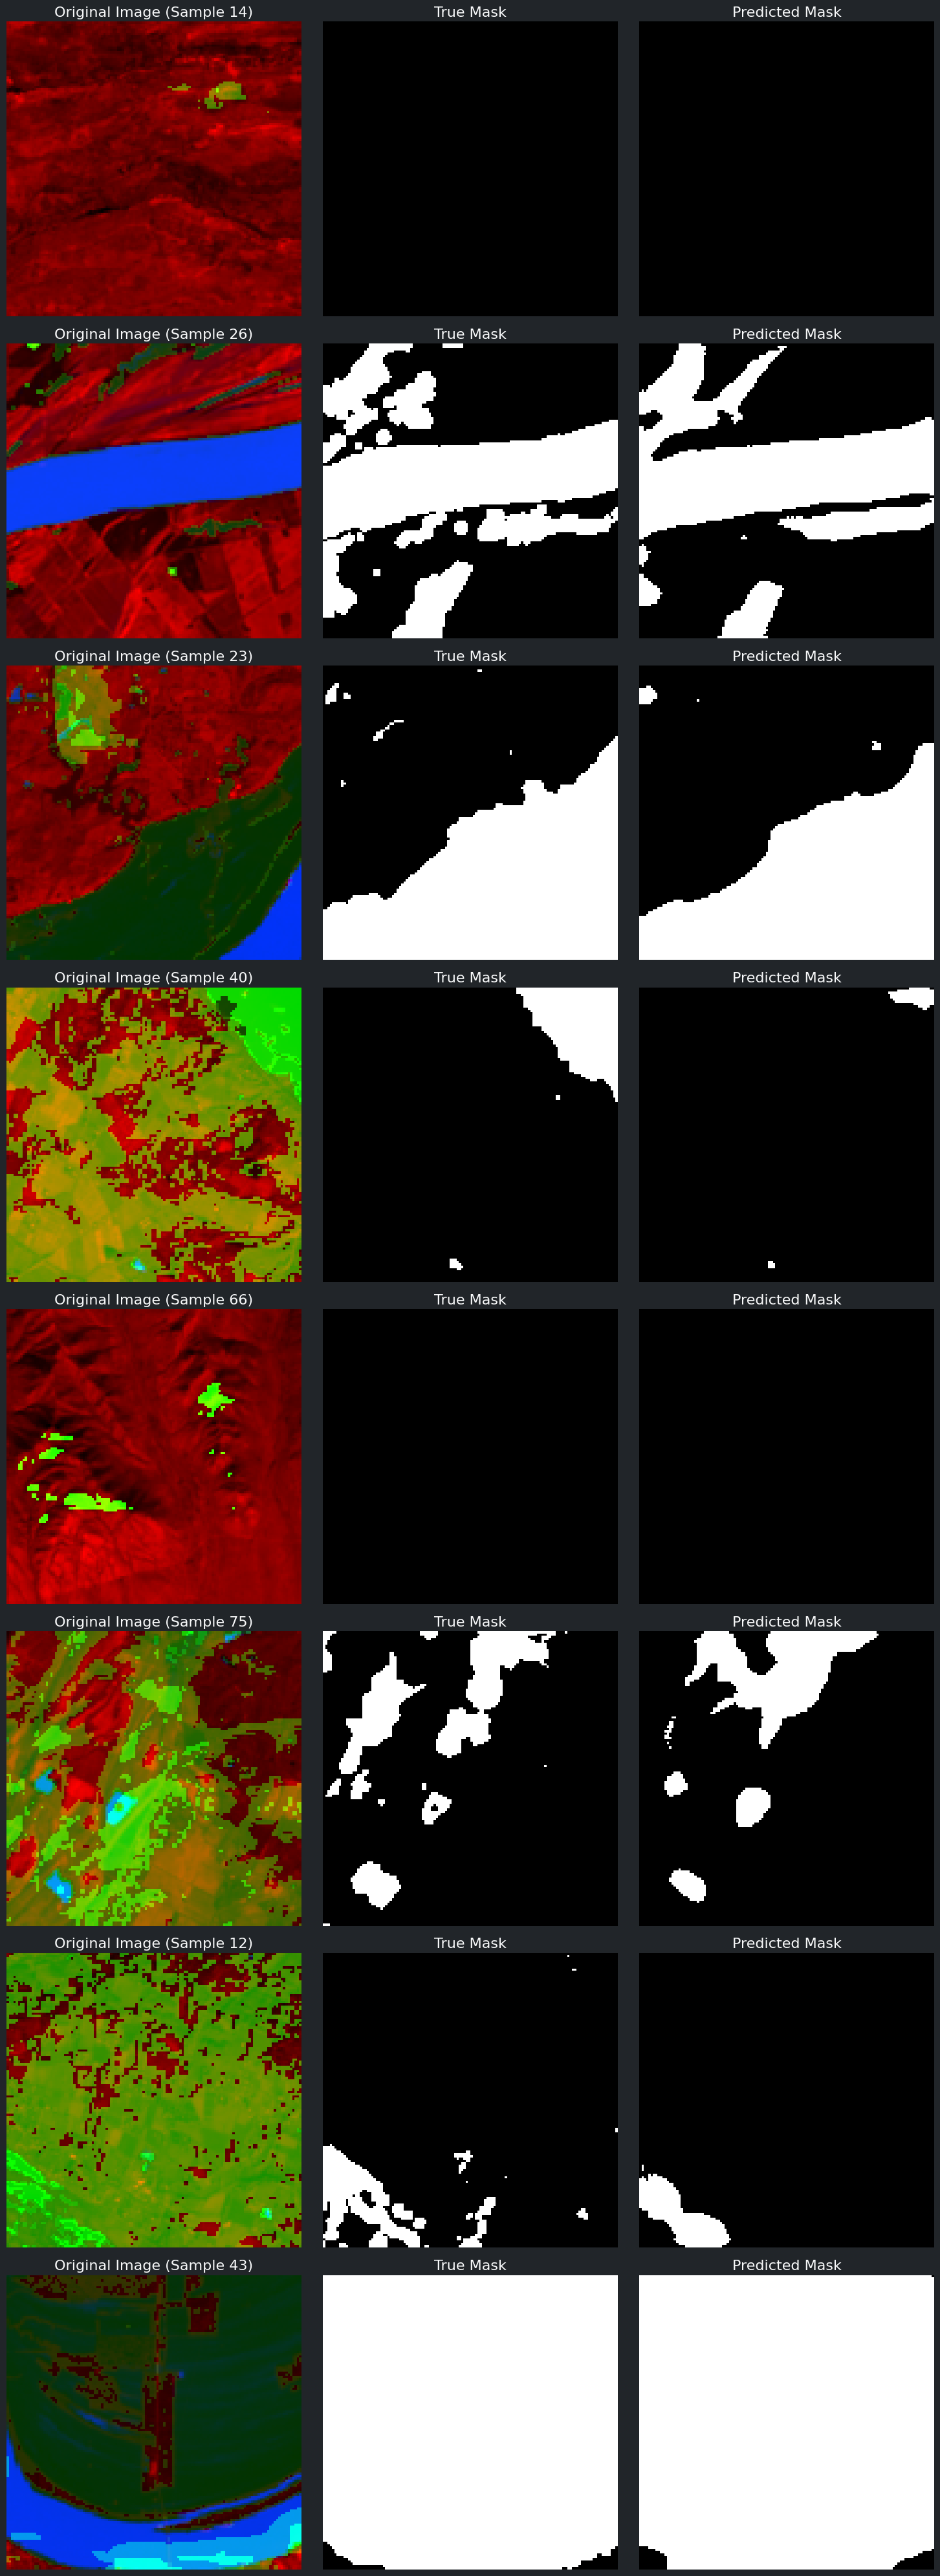

In [112]:
from tensorflow.keras.models import load_model

# Load the best model
best_model_path = '/kaggle/working/best_unet_model.keras'
loaded_model = load_model(best_model_path, custom_objects={'dice_coefficient': dice_coefficient, 'iou': iou})

# Select 4 random images from the test set
num_test_images = 8
random_indices = random.sample(range(len(X_val)), num_test_images)

plt.figure(figsize=(15, num_test_images * 5))

for i, idx in enumerate(random_indices):
    # Get the original image, true mask, and predicted mask
    original_image = X_val[idx]
    true_mask = y_val[idx]
    predicted_mask = loaded_model.predict(np.expand_dims(original_image, axis=0))[0]
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8) # Binarize prediction

    # Plot original image (using a few bands for visualization)
    plt.subplot(num_test_images, 3, i * 3 + 1)
    # Assuming bands 3, 2, 1 (0-indexed) are suitable for an RGB-like composite
    # Adjust indices if your selected bands are different and you want a specific composite
    # If not an RGB composite, you can display a single band or a grayscale version
    if original_image.shape[-1] >= 3:
         # Attempt to create a simple RGB composite from the first 3 selected bands
         # Note: This might not be a true color composite depending on which bands were selected
         display_img = original_image[:, :, :3]
         plt.imshow(display_img)
    else:
        # If less than 3 bands, display the first band in grayscale
        plt.imshow(original_image[:, :, 0], cmap='gray')

    plt.title(f'Original Image (Sample {idx})')
    plt.axis('off')

    # Plot true mask
    plt.subplot(num_test_images, 3, i * 3 + 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(num_test_images, 3, i * 3 + 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Freezing some layers

In [83]:
model = Unet(
    backbone_name=BACKBONE,
    encoder_weights='imagenet',
    input_shape=(128, 128, 3),
    classes=1,
    activation='sigmoid'
)

In [84]:
# model.summary()

In [85]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 data
1 bn_data
2 zero_padding2d_54
3 conv0
4 bn0
5 relu0
6 zero_padding2d_55
7 pooling0
8 stage1_unit1_bn1
9 stage1_unit1_relu1
10 stage1_unit1_conv1
11 stage1_unit1_bn2
12 stage1_unit1_relu2
13 zero_padding2d_56
14 stage1_unit1_conv2
15 stage1_unit1_bn3
16 stage1_unit1_relu3
17 stage1_unit1_conv3
18 stage1_unit1_sc
19 add_48
20 stage1_unit2_bn1
21 stage1_unit2_relu1
22 stage1_unit2_conv1
23 stage1_unit2_bn2
24 stage1_unit2_relu2
25 zero_padding2d_57
26 stage1_unit2_conv2
27 stage1_unit2_bn3
28 stage1_unit2_relu3
29 stage1_unit2_conv3
30 add_49
31 stage1_unit3_bn1
32 stage1_unit3_relu1
33 stage1_unit3_conv1
34 stage1_unit3_bn2
35 stage1_unit3_relu2
36 zero_padding2d_58
37 stage1_unit3_conv2
38 stage1_unit3_bn3
39 stage1_unit3_relu3
40 stage1_unit3_conv3
41 add_50
42 stage2_unit1_bn1
43 stage2_unit1_relu1
44 stage2_unit1_conv1
45 stage2_unit1_bn2
46 stage2_unit1_relu2
47 zero_padding2d_59
48 stage2_unit1_conv2
49 stage2_unit1_bn3
50 stage2_unit1_relu3
51 stage2_unit1_conv3
52 stage2_u

In [86]:
for layer in model.layers[:188]: # freeze the encoder
    layer.trainable = False


In [87]:
for layer in model.layers:
    print(f"{layer.name} - Trainable: {layer.trainable}")


data - Trainable: False
bn_data - Trainable: False
zero_padding2d_54 - Trainable: False
conv0 - Trainable: False
bn0 - Trainable: False
relu0 - Trainable: False
zero_padding2d_55 - Trainable: False
pooling0 - Trainable: False
stage1_unit1_bn1 - Trainable: False
stage1_unit1_relu1 - Trainable: False
stage1_unit1_conv1 - Trainable: False
stage1_unit1_bn2 - Trainable: False
stage1_unit1_relu2 - Trainable: False
zero_padding2d_56 - Trainable: False
stage1_unit1_conv2 - Trainable: False
stage1_unit1_bn3 - Trainable: False
stage1_unit1_relu3 - Trainable: False
stage1_unit1_conv3 - Trainable: False
stage1_unit1_sc - Trainable: False
add_48 - Trainable: False
stage1_unit2_bn1 - Trainable: False
stage1_unit2_relu1 - Trainable: False
stage1_unit2_conv1 - Trainable: False
stage1_unit2_bn2 - Trainable: False
stage1_unit2_relu2 - Trainable: False
zero_padding2d_57 - Trainable: False
stage1_unit2_conv2 - Trainable: False
stage1_unit2_bn3 - Trainable: False
stage1_unit2_relu3 - Trainable: False
stage

In [88]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", dice_coefficient, iou]
)

In [89]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    checkpoint_callback
]

In [90]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[callbacks],
    batch_size=16
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.5928 - dice_coefficient: 0.2824 - iou: 0.1684 - loss: 0.6897
Epoch 1: val_iou did not improve from 0.69603
14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5965 - dice_coefficient: 0.2844 - iou: 0.1697 - loss: 0.6873 - val_accuracy: 0.5408 - val_dice_coefficient: 0.3067 - val_iou: 0.1822 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7553 - dice_coefficient: 0.2672 - iou: 0.1546 - loss: 0.5653
Epoch 2: val_iou did not improve from 0.69603
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7534 - dice_coefficient: 0.2680 - iou: 0.1551 - loss: 0.5672 - val_accuracy: 0.7428 - val_dice_coefficient: 0.2801 - val_iou: 0.1636 - val_loss: 0.6030 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6885 - dice_coefficient: 0.2955 - iou: 0.1747 - loss: 0.6256
Epoch 3: val_iou did not improve from 0.69603
14/14 ━━━━━━━━━━━━━━━

## unfreeze 30%

In [91]:
# Build the model
model = Unet(
    backbone_name=BACKBONE,
    encoder_weights='imagenet',
    input_shape=(128, 128, 3),
    classes=1,
    activation='sigmoid'
)

# Step 1: Count total layers
total_layers = len(model.layers)
print(f"Total layers: {total_layers}")

# Step 2: Calculate the split index
freeze_until = int(total_layers * 0.7)  # Freeze first 70%, unfreeze last 30%

# Step 3 & 4: Set trainable attribute
for i, layer in enumerate(model.layers):
    layer.trainable = i >= freeze_until

# Optional: Print to verify
for layer in model.layers:
    print(f"{layer.name} - Trainable: {layer.trainable}")


Total layers: 231
data - Trainable: False
bn_data - Trainable: False
zero_padding2d_72 - Trainable: False
conv0 - Trainable: False
bn0 - Trainable: False
relu0 - Trainable: False
zero_padding2d_73 - Trainable: False
pooling0 - Trainable: False
stage1_unit1_bn1 - Trainable: False
stage1_unit1_relu1 - Trainable: False
stage1_unit1_conv1 - Trainable: False
stage1_unit1_bn2 - Trainable: False
stage1_unit1_relu2 - Trainable: False
zero_padding2d_74 - Trainable: False
stage1_unit1_conv2 - Trainable: False
stage1_unit1_bn3 - Trainable: False
stage1_unit1_relu3 - Trainable: False
stage1_unit1_conv3 - Trainable: False
stage1_unit1_sc - Trainable: False
add_64 - Trainable: False
stage1_unit2_bn1 - Trainable: False
stage1_unit2_relu1 - Trainable: False
stage1_unit2_conv1 - Trainable: False
stage1_unit2_bn2 - Trainable: False
stage1_unit2_relu2 - Trainable: False
zero_padding2d_75 - Trainable: False
stage1_unit2_conv2 - Trainable: False
stage1_unit2_bn3 - Trainable: False
stage1_unit2_relu3 - Trai

In [92]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", dice_coefficient, iou]
)

# Train with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=callbacks,
    batch_size=16
)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.4216 - dice_coefficient: 0.3805 - iou: 0.2359 - loss: 0.8335
Epoch 1: val_iou did not improve from 0.69603
14/14 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4286 - dice_coefficient: 0.3789 - iou: 0.2346 - loss: 0.8274 - val_accuracy: 0.7331 - val_dice_coefficient: 0.1225 - val_iou: 0.0654 - val_loss: 2.8923 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7308 - dice_coefficient: 0.2821 - iou: 0.1666 - loss: 0.5989
Epoch 2: val_iou did not improve from 0.69603
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7301 - dice_coefficient: 0.2826 - iou: 0.1668 - loss: 0.5991 - val_accuracy: 0.7673 - val_dice_coefficient: 0.0308 - val_iou: 0.0157 - val_loss: 3.1777 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7042 - dice_coefficient: 0.2928 - iou: 0.1718 - loss: 0.6087
Epoch 3: val_iou did not improve from 0.69603
14/14 ━━━━━━━━━━━━━━

## The best Model is which without Freezing !